# Data Loader

In [ ]:
image_dir = "/content/drive/MyDrive/ThreevAssignment/images/livecell_train_val_images"
annotation_file = "/content/drive/MyDrive/ThreevAssignment/livecell_coco_train.json"

from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from tqdm import tqdm

from data_torch import LIVCellDataset

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

dataset = LIVCellDataset(image_dir, annotation_file, img_size=512,transform = transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device)

cpu


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# Tensor shape check
I=0
for images,masks in dataloader:
    # print(i)
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)
    I+=1
    if I==5:
      break

# Training

In [ ]:
# Training
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):

        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
    torch.save(model.state_dict(), f"/content/drive/MyDrive/ThreevAssignment/model_files/model_dict_{epoch+1}.pth")
    print("Model saved successfully.")

# Save trained model
torch.save(model.state_dict(), "unet_final_model.pth")
print("Model saved successfully.")

# Testing

In [ ]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

from data_torch import LIVCellDataset


image_dir = "/content/drive/MyDrive/ThreevAssignment/images/livecell_test_images"
json_file = "/content/drive/MyDrive/ThreevAssignment/livecell_coco_test.json"

test_dataset = LIVCellDataset(image_dir, json_file, img_size=512)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/drive/MyDrive/ThreevAssignment/model_files_prebuild/unet_final_model.pth",map_location=torch.device('cpu')))
model.to(device)
model.eval()

criterion = nn.BCELoss()


In [ ]:
I=0
for images,masks in test_loader:
    # print(i)
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)
    I+=1
    if I==5:
      break

In [ ]:
from tqdm import tqdm
test_loss = 0.0

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}")



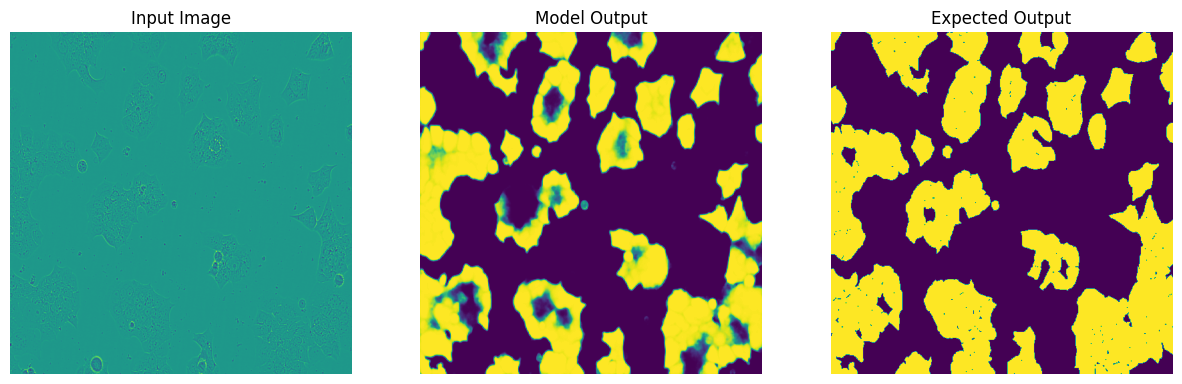

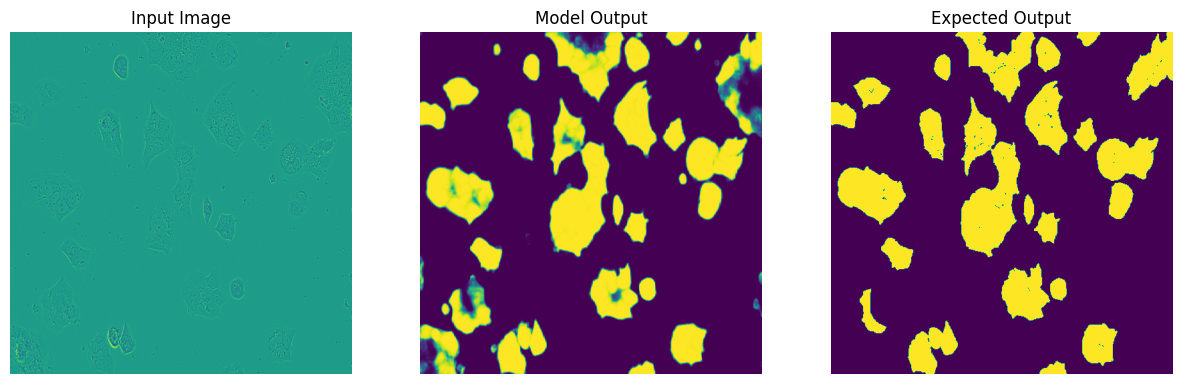

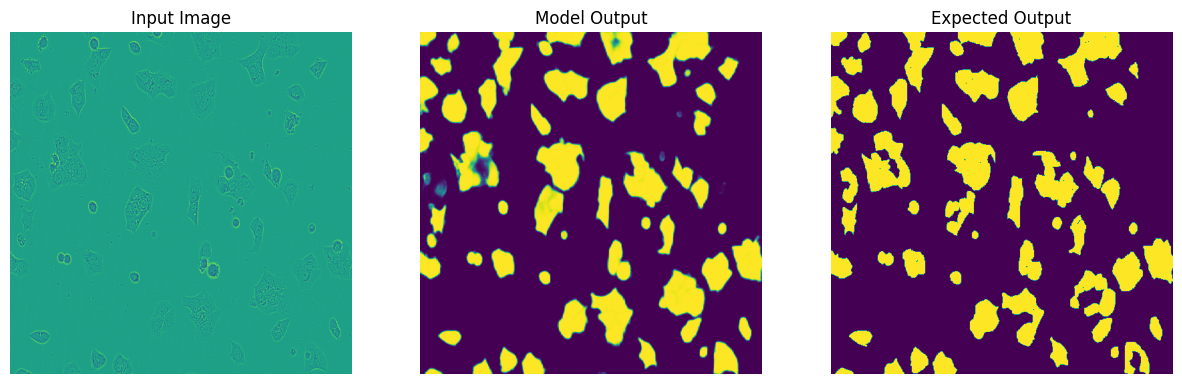

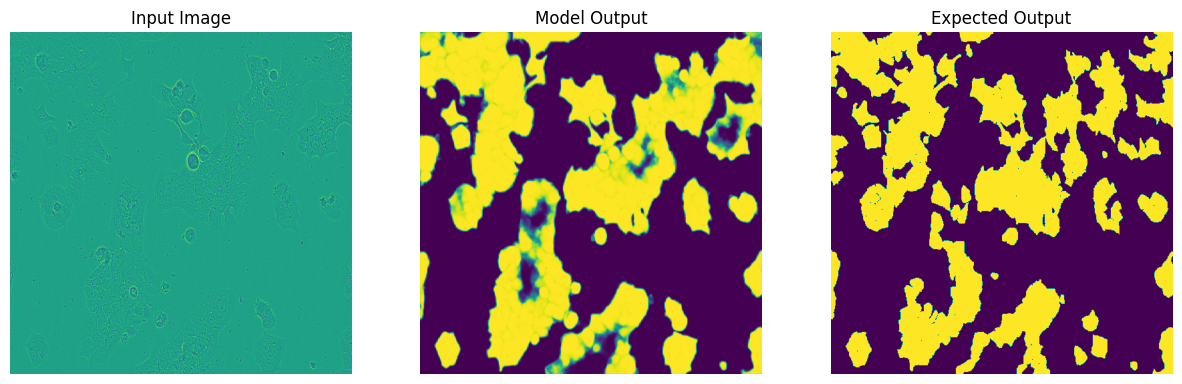

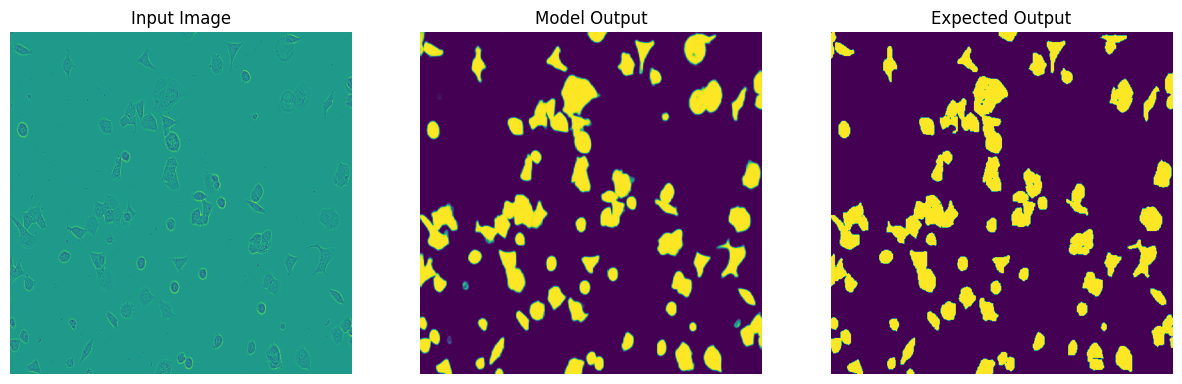

In [7]:


def visualize_model_output(model, test_loader, device):

    model.eval()
    with torch.no_grad():

        for batch_idx, (images, annotations) in enumerate(test_loader):

            images = images.to(device)
            annotations = annotations.to(device)

            outputs = model(images)

            outputs = outputs.cpu()
            annotations = annotations.cpu()
            images = images.cpu()

            batch_size = images.size(0)
            num_samples = min(batch_size, 5)
            for i in range(num_samples):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                axes[0].imshow(images[i].permute(1, 2, 0))
                axes[0].set_title("Input Image")
                axes[0].axis("off")

                axes[1].imshow(outputs[i].squeeze(), cmap='viridis')
                axes[1].set_title("Model Output")
                axes[1].axis("off")

                axes[2].imshow(annotations[i].squeeze(), cmap='viridis')
                axes[2].set_title("Expected Output")
                axes[2].axis("off")

                plt.show()

            break

visualize_model_output(model, test_loader, device)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
